In [3]:
import numpy as np 
import urdf2casadi.urdfparser as u2c
from urdf2casadi.geometry import plucker
from urdf_parser_py.urdf import URDF, Pose
#import PyKDL as kdl
#import kdl_parser.kdl_parser_py.kdl_parser_py.urdf as kdlurdf
from timeit import Timer, timeit, repeat
import rbdl
import pybullet as pb


In [4]:
def median(lst):
    n = len(lst)
    if n < 1:
            return None
    if n % 2 == 1:
            return sorted(lst)[n//2]
    else:
            return sum(sorted(lst)[n//2-1:n//2+1])/2.0
        
def average(lst): 
    return sum(lst) / len(lst) 

#def C_kdl_func():
#    for j in range(njoints):
#        q_kdl[j] = (qmax[j] - qmin[j])*np.random.rand()-(qmax[j] - qmin[j])/2
        #qdot_kdl[j] = (qmax[j] - qmin[j])*np.random.rand()-(qmax[j] - qmin[j])/2

#    kdl.ChainDynParam(kdlmodel, g_kdl).JntToCoriolis(q_kdl, qdot_kdl, C_kdl)

#timeit_kdl = repeat("M_kdl_func()", setup = "from __main__ import M_kdl_func", repeat = nrepeat, number = nitr)
#mintime_kdl[i] = min(timeit_kdl)
#mediantime_kdl[i] = median(timeit_kdl)
#averagetime_kdl[i] = average(timeit_kdl)

def aba_u2c_func():   
    for j in range(njoints):
        q_none = (qmax[j] - qmin[j])*np.random.rand()-(qmax[j] - qmin[j])/2
        qdot_none[j] = (qmax[j] - qmin[j])*np.random.rand()-(qmax[j] - qmin[j])/2
        tau_none[j] = (qmax[j] - qmin[j])*np.random.rand()-(qmax[j] - qmin[j])/2

    aba_u2c(q_none, qdot_none, tau_none)
    
def crba_u2c_func():
    for j in range(njoints):
        q_none[j] = (qmax[j] - qmin[j])*np.random.rand()-(qmax[j] - qmin[j])/2
        qdot_none[j] = (qmax[j] - qmin[j])*np.random.rand()-(qmax[j] - qmin[j])/2
        tau_none[j] = (qmax[j] - qmin[j])*np.random.rand()-(qmax[j] - qmin[j])/2
    
    crba_u2c(q_none, qdot_none, tau_none)
    
    
def fd_rbdl_func():
    for j in range(njoints):
        q_np[j] = (qmax[j] - qmin[j])*np.random.rand()-(qmax[j] - qmin[j])/2
        qdot_np[j] = (qmax[j] - qmin[j])*np.random.rand()-(qmax[j] - qmin[j])/2
        tau_np[j] = (qmax[j] - qmin[j])*np.random.rand()-(qmax[j] - qmin[j])/2

    rbdl.ForwardDynamics(rbdlmodel, q_np, qdot_np, tau_np, qddot_np)
    #rbdl.ForwardDynamicsLagrangian(rbdlmodel, q_np, qdot_np, tau_np, qddot_np)



In [ ]:
#pbmodel = pb.loadURDF("pantilt.urdf")

#pbmodel = pb.loadURDF("/urdf4timing/1dof.urdf")
ndofs = 60
urdf_nr = list(range(ndofs + 1))
urdf_nr.pop(0)

#storage for timing data

mediantime_u2c_aba = [None]*ndofs
mediantime_rbdl = [None]*ndofs
mediantime_u2c_crba = [None]*ndofs
#mintime_kdl = [None]*ndofs
mintime_u2c_aba = [None]*ndofs
mintime_rbdl = [None]*ndofs
mintime_u2c_crba = [None]*ndofs
#averagetime_kdl = [None]*ndofs
averagetime_u2c_aba = [None]*ndofs
averagetime_rbdl = [None]*ndofs
averagetime_u2c_crba = [None]*ndofs


nitr = 10
nrepeat = 10
    
for i in range(ndofs):    
    print i
    path_to_urdf = "/home/lmjohann/urdf2casadi/examples/timing/urdf4timing/" + str(urdf_nr[i]) + "dof.urdf"
    end_link = "link" + str(urdf_nr[i])
    root = 'base_link'
    tip = end_link
    
    #ok, kdl_tree = kdlurdf.treeFromFile(path_to_urdf)
    #kdlmodel = kdl_tree.getChain(root,tip)
    
    rbdlmodel = rbdl.loadModel(path_to_urdf)
    #pbmodel = pb.loadURDF(path_to_urdf, useFixedBase=True)
    asd = u2c.URDFparser()
    robot_desc = asd.from_file(path_to_urdf)
    
    jlist, names, qmax, qmin = asd.get_joint_info(root, tip)
    njoints = len(jlist)

    #g_kdl = kdl.Vector()
    #M_kdl = kdl.JntSpaceInertiaMatrix(njoints)
    
    #rbdl declarations
    q_np = np.zeros(njoints)
    qdot_np = np.zeros(njoints)
    qddot_np = np.zeros(njoints)
    tau_np = np.zeros(njoints)
    
    #kdl declatations
    #q_kdl = kdl.JntArray(njoints)
    #qdot_kdl = kdl.JntArray(njoints)
    
    #u2c and pybullet declarations
    q_none = [None]*njoints
    qdot_none = [None]*njoints
    C_pb = [None]*njoints
    tau_none = [None]*njoints
        
    
    gravity = [0, 0, -9.81]
    
    #aba_u2c = asd.get_forward_dynamics_aba(root, tip)
    #timeit_u2c_aba = repeat("aba_u2c_func()", setup = "from __main__ import aba_u2c_func", repeat = nrepeat, number = nitr)
    #mintime_u2c_aba[i] = min(timeit_u2c_aba)
    #mediantime_u2c_aba[i] = median(timeit_u2c_aba)
    #averagetime_u2c_aba[i] = average(timeit_u2c_aba)
    
    crba_u2c = asd.get_forward_dynamics_crba(root, tip)
    timeit_crba = repeat("crba_u2c_func()", setup = "from __main__ import crba_u2c_func", repeat = nrepeat, number = nitr)
    mintime_u2c_crba[i] = min(timeit_crba)
    mediantime_u2c_crba[i] = median(timeit_crba)
    averagetime_u2c_crba[i] = average(timeit_crba)
    
    #timeit_rbdl = repeat("fd_rbdl_func()", setup = "from __main__ import fd_rbdl_func", repeat = nrepeat, number = nitr)
    #mintime_rbdl[i] = min(timeit_rbdl)
    #mediantime_rbdl[i] = median(timeit_rbdl)
    #averagetime_rbdl[i] = average(timeit_rbdl)
    
    

0
/home/lmjohann/urdf2casadi/examples/timing/urdf4timing/1dof.urdf
1
/home/lmjohann/urdf2casadi/examples/timing/urdf4timing/2dof.urdf
2
/home/lmjohann/urdf2casadi/examples/timing/urdf4timing/3dof.urdf
3
/home/lmjohann/urdf2casadi/examples/timing/urdf4timing/4dof.urdf
4
/home/lmjohann/urdf2casadi/examples/timing/urdf4timing/5dof.urdf
5
/home/lmjohann/urdf2casadi/examples/timing/urdf4timing/6dof.urdf
6
/home/lmjohann/urdf2casadi/examples/timing/urdf4timing/7dof.urdf
7
/home/lmjohann/urdf2casadi/examples/timing/urdf4timing/8dof.urdf
8
/home/lmjohann/urdf2casadi/examples/timing/urdf4timing/9dof.urdf
9
/home/lmjohann/urdf2casadi/examples/timing/urdf4timing/10dof.urdf
10
/home/lmjohann/urdf2casadi/examples/timing/urdf4timing/11dof.urdf
11
/home/lmjohann/urdf2casadi/examples/timing/urdf4timing/12dof.urdf
12
/home/lmjohann/urdf2casadi/examples/timing/urdf4timing/13dof.urdf
13
/home/lmjohann/urdf2casadi/examples/timing/urdf4timing/14dof.urdf
14
/home/lmjohann/urdf2casadi/examples/timing/urdf4ti

In [27]:
print timeit_u2c_aba[60]

0.000144004821777


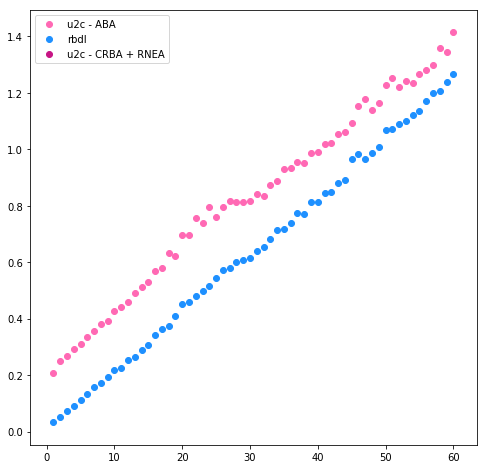

In [35]:
import matplotlib.pyplot as plt
import pandas as pd

joint_nr = list(range(ndofs + 1))
joint_nr.pop(0)
med_fig = plt.figure(figsize = (8, 8))
#plt.scatter(joint_nr, mediantime_kdl, c='r', marker='x', label='kdl')
plt.scatter(joint_nr, mintime_u2c_aba, c='hotpink', label='u2c - ABA')
plt.scatter(joint_nr, mediantime_rbdl, c='dodgerblue', label='rbdl')
plt.scatter(joint_nr, mediantime_u2c_crba, c='mediumvioletred', label='u2c - CRBA + RNEA')
plt.legend(loc='upper left')
#plt.ylim(0, 0.00014)
med_fig.show()

[Text(0,0,'U2C - ABA'), Text(0,0,'U2C - CRBA + RNEA')]

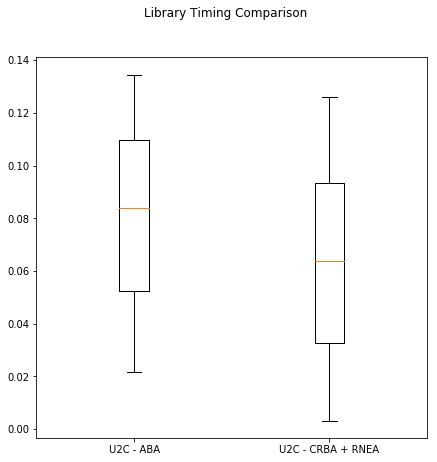

In [9]:
timing_scores = [mediantime_u2c_aba, mediantime_rbdl]
names = ["U2C - ABA", "U2C - CRBA + RNEA", "RBDL"]
boxplot = plt.figure(figsize = (7, 7))
boxplot.suptitle("Library Timing Comparison")
ax = boxplot.add_subplot(111)
ax.boxplot(timing_scores)
#plt.boxplot(timing_scores)
ax.set_xticklabels(names)


In [36]:
print "fd_mediantime_aba =",mintime_u2c_aba
print "fd_mediantime_rbdl =",mediantime_rbdl

fd_mediantime_aba = [0.2085869312286377, 0.24915289878845215, 0.2678999900817871, 0.29242801666259766, 0.3108079433441162, 0.33443284034729004, 0.35774803161621094, 0.38053107261657715, 0.3911280632019043, 0.42827916145324707, 0.44278597831726074, 0.45998501777648926, 0.49125003814697266, 0.5134181976318359, 0.5306839942932129, 0.5676910877227783, 0.5783050060272217, 0.6313538551330566, 0.6234900951385498, 0.6948549747467041, 0.6966760158538818, 0.7576069831848145, 0.7372899055480957, 0.7968251705169678, 0.7617740631103516, 0.7938261032104492, 0.8182358741760254, 0.8144850730895996, 0.8131420612335205, 0.815310001373291, 0.843163013458252, 0.833543062210083, 0.8741939067840576, 0.8864428997039795, 0.9304099082946777, 0.9332060813903809, 0.9541900157928467, 0.9532480239868164, 0.9858310222625732, 0.9913599491119385, 1.0201830863952637, 1.0237998962402344, 1.055022954940796, 1.0598869323730469, 1.0922651290893555, 1.1539769172668457, 1.1791629791259766, 1.140589952468872, 1.1646740436553